In [1]:
from data import *

folder_path = "Data/TestRecordings"
participant = "AruerisT1"

rec = Recording(os.path.join(folder_path, participant))
rec.calc_events_all_conditions()

f:\Python\GazeBasedSelection\data.py:26: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  scene_data = pd.read_table(os.path.join(path, condition, "SceneData.tsv"), sep="\t", decimal=",")
100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


In [2]:
round_results = rec.summarize_rounds("nod")

In [3]:
rec["nod"]["SceneData"].Msg.unique()

array([nan, 'StartGame', 'Correct target selected', 'MainTargetDestroyed',
       'Incorrect target selected', 'NonMaintargetDestroyed', 'EndGame'],
      dtype=object)

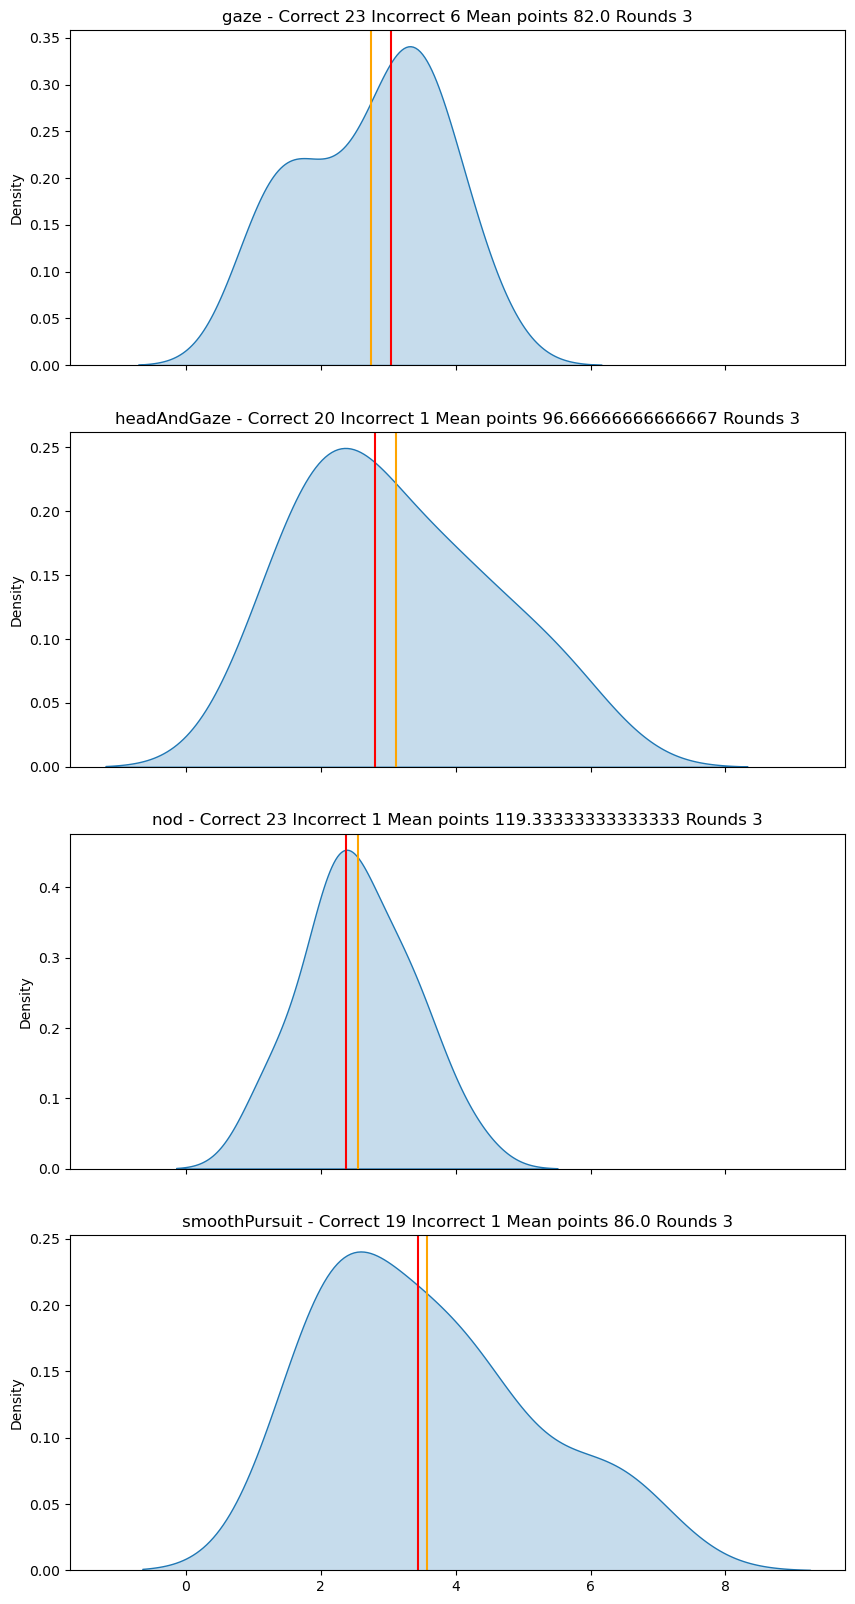

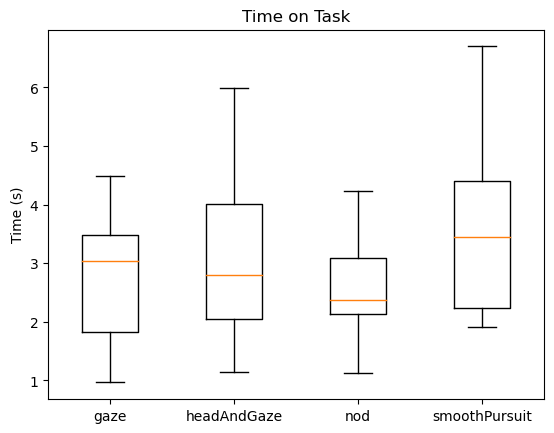

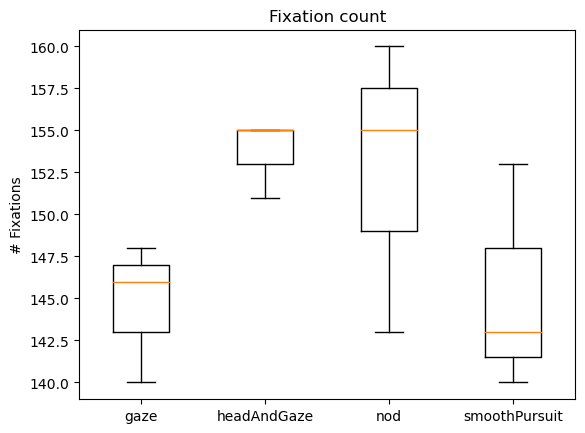

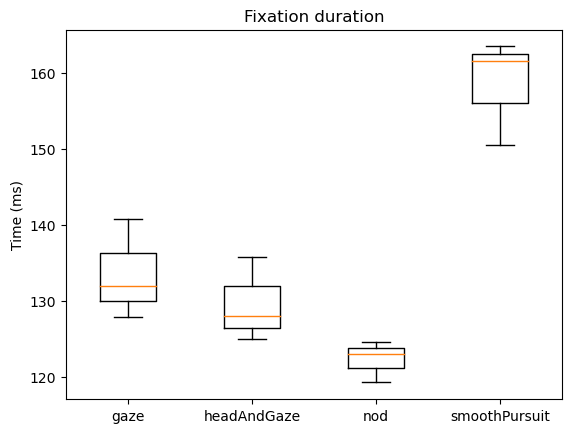

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(len(Recording.conditions), sharex=True, figsize=(10,20))
all_time_on_tasks = dict()
all_fixation_count = dict()
all_fixation_duration = dict()
for i, condition in enumerate(Recording.conditions):
    round_results = rec.summarize_rounds(condition)
    time_on_task = list()
    correct = 0
    incorrect = 0
    rounds_without_change = len(round_results)
    points = list()
    fixation_count = list()
    fixation_duration = list()
    for k in round_results:
        time_on_task += round_results[k]["TimeOnTask"]
        correct += round_results[k]["Correct"]
        incorrect += round_results[k]["Incorrect"]
        points.append(round_results[k]["Points"])
        fixation_count.append(round_results[k]["FixationCount"])
        fixation_duration.append(round_results[k]["MeanFixationDuration"])
    sns.kdeplot(time_on_task, fill=True, ax=axs[i])
    y_min, y_max = axs[i].get_ylim()
    axs[i].axvline(np.mean(time_on_task), 0, 1, color="orange")
    axs[i].axvline(np.median(time_on_task), 0, 1, color="red")
    axs[i].set_title(f"{condition} - Correct {correct} Incorrect {incorrect} Mean points {np.mean(points)} Rounds {rounds_without_change}")
    all_time_on_tasks[condition] = time_on_task
    all_fixation_count[condition] = fixation_count
    all_fixation_duration[condition] = fixation_duration
plt.show()

def create_boxplot(d, title, ylabel):
    _, ax = plt.subplots()
    ax.boxplot(d.values())
    ax.set_xticklabels(d.keys())
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

create_boxplot(all_time_on_tasks, "Time on Task", "Time (s)")
create_boxplot(all_fixation_count, "Fixation count", "# Fixations")
create_boxplot(all_fixation_duration, "Fixation duration", "Time (ms)")

# fig, ax = plt.subplots()
# ax.boxplot(all_time_on_tasks.values())
# ax.set_xticklabels(all_time_on_tasks.keys())
# ax.set_ylabel("Time on selection (s)")
# ax.set_title("Time on Task")
# plt.show()



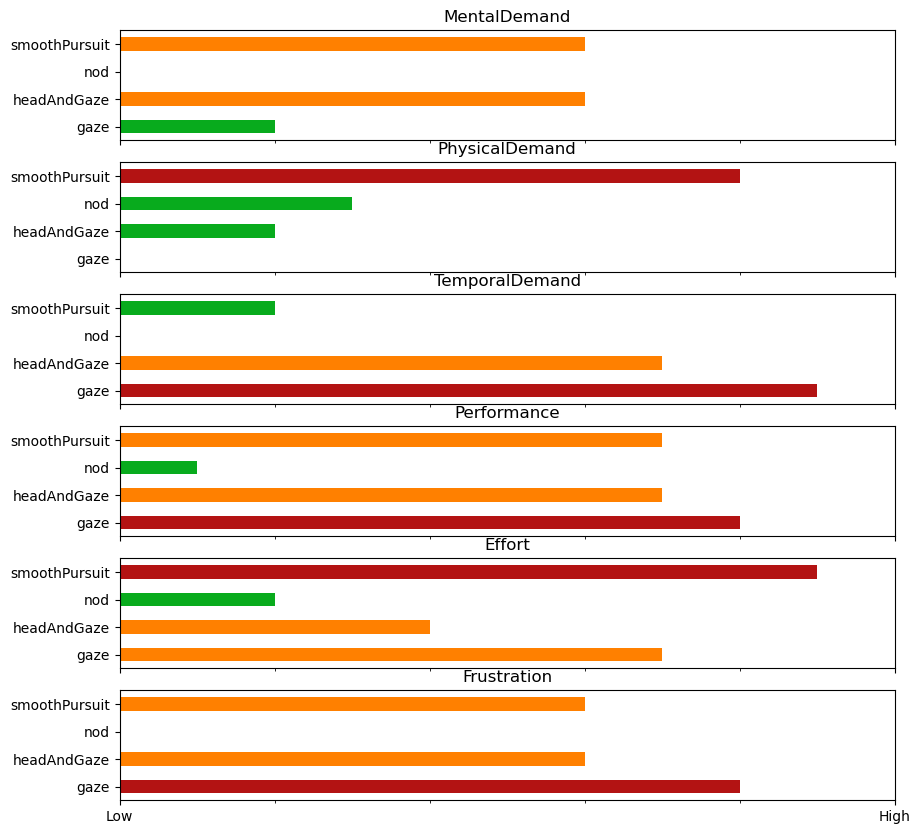

In [5]:
import matplotlib.pyplot as plt
import utils
_, axs = plt.subplots(len(rec["answers"]), sharex=True, sharey=True, figsize=(10, 10))
i = 0
for question, row in rec["answers"].iterrows():
    row.plot(
        kind="barh", 
        color = [utils.get_color(x) for x in row],
        title=question.replace("tlx_", ""), 
        ax=axs[i])
    axs[i].set_xticks([0, 100], ["Low", "High"])
    i += 1
plt.show()

In [6]:
scene_data = rec["nod"]["SceneData"]
scene_data.loc[scene_data.Msg.apply(lambda x: "Correct target selected" in str(x)), ["EyeDataTimestamp", "Msg"]]

,EyeDataTimestamp,Msg
584,1723459098985,Correct target selected
910,1723459102605,Correct target selected
1292,1723459106849,Correct target selected
1554,1723459109757,Correct target selected
1887,1723459113457,Correct target selected
2079,1723459115588,Correct target selected
2333,1723459118409,Correct target selected
2804,1723459123640,Correct target selected
3575,1723459132204,Correct target selected
3869,1723459135468,Correct target selected


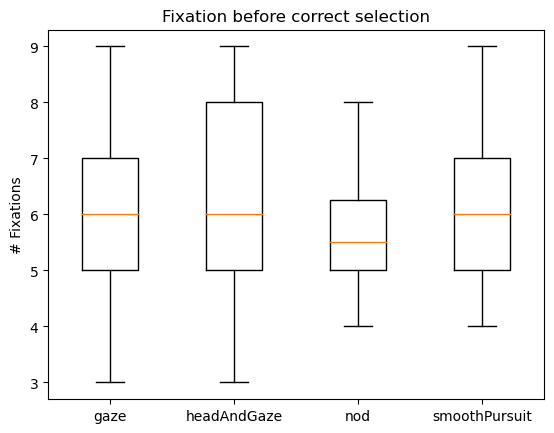

In [7]:
count_fixations = dict()
condition = "nod"
for condition in Recording.conditions:
    count_fixations[condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end), ["System Timestamp", "Event"]]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Correct target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            fixations = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - 1000) & (gaze_round["Event"] != "Saccade"), "Event"].unique()
            count_fixations[condition].append(len(fixations))

create_boxplot(count_fixations, "Fixation before correct selection", "# Fixations")


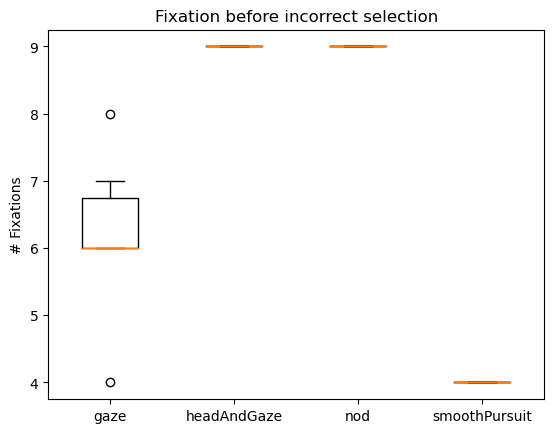

In [8]:
count_fixations = dict()

for condition in Recording.conditions:
    count_fixations[condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end), ["System Timestamp", "Event"]]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Incorrect target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            fixations = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - 1000) & (gaze_round["Event"] != "Saccade"), "Event"].unique()
            count_fixations[condition].append(len(fixations))

create_boxplot(count_fixations, "Fixation before incorrect selection", "# Fixations")


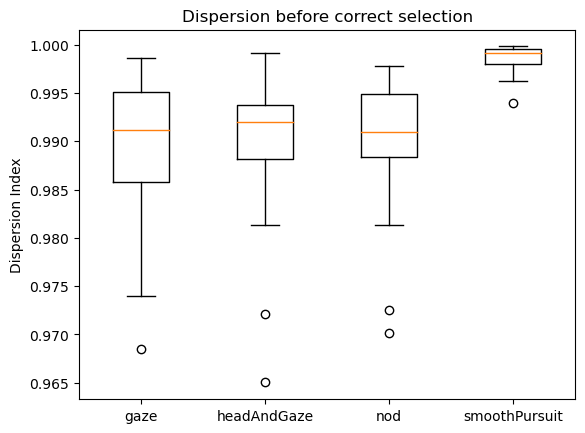

In [9]:
import utils
dispersion = dict()
time_window = 1000
condition = "nod"
errors = list()
for condition in Recording.conditions:
    dispersion[condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end)]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Correct target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            gvs = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - time_window) & (gaze_round["Event"] != "Saccade"), ["Local Gaze Direction %s" % x for x in ["X", "Y", "Z"]]].to_numpy()
            disp = utils.calc_dispersion_index(gvs)
            dispersion[condition].append(disp)
            if disp > 1:
                errors.append(gvs)

create_boxplot(dispersion, "Dispersion before correct selection", "Dispersion Index")

<Axes: >

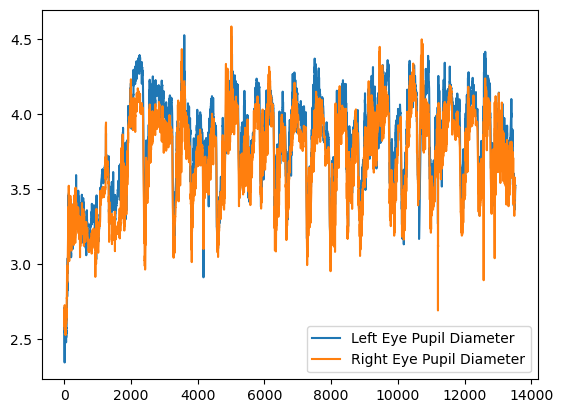

In [10]:
gaze120.loc[:, [x for x in gaze120.columns if "Diameter" in x]].plot()

In [11]:
[x for x in gaze120.columns if "Diameter" in x]

['Left Eye Pupil Diameter', 'Right Eye Pupil Diameter']

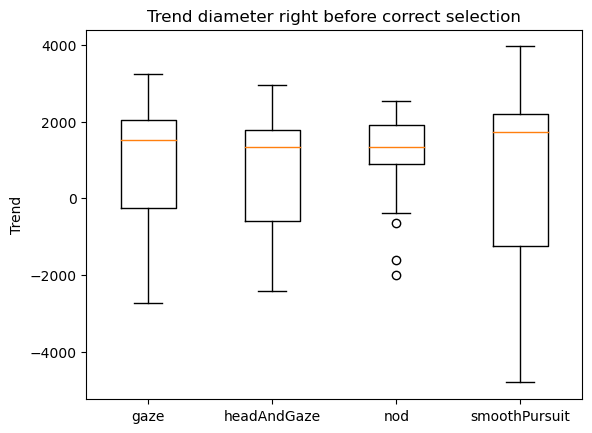

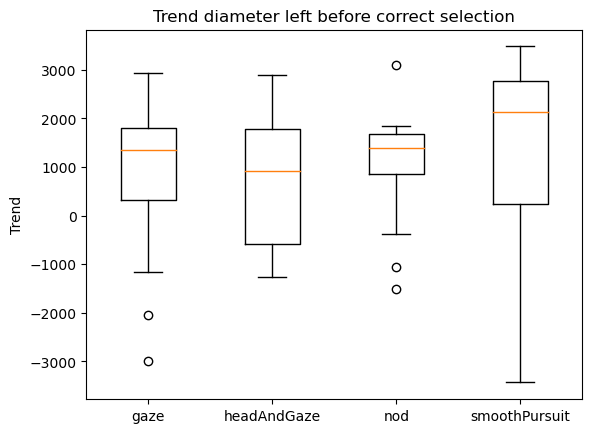

In [26]:
import utils
trend = {"Right": dict(), "Left": dict()}
time_window = 1000
condition = "nod"
errors = list()
for condition in Recording.conditions:
    trend["Right"][condition] = list()
    trend["Left"][condition] = list()
    gaze120 = rec[condition]["Gaze120"]
    scene_data = rec[condition]["SceneData"]
    final_rounds = rec.get_final_rounds(condition)
    for _, row in final_rounds.iterrows():
        start, end = row[["StartDeviceTime", "EndDeviceTime"]]
        gaze_round = gaze120.loc[(gaze120["System Timestamp"] >= start) & (gaze120["System Timestamp"] <= end)]
        scene_data_round = scene_data.loc[(scene_data["EyeDataTimestamp"] >= start) & (scene_data["EyeDataTimestamp"] <= end), ["EyeDataTimestamp", "Msg"]]
        t_destroy = scene_data_round.loc[scene_data_round.Msg.apply(lambda x: "Correct target selected" in str(x)), "EyeDataTimestamp"].to_numpy()
        for t in t_destroy:
            diameters_left = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - time_window) & (gaze_round["Event"] != "Saccade"), 'Left Eye Pupil Diameter'].to_numpy()
            diameters_right = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - time_window) & (gaze_round["Event"] != "Saccade"), 'Right Eye Pupil Diameter'].to_numpy()
            time = gaze_round.loc[(gaze_round["System Timestamp"] < t) & (gaze_round["System Timestamp"] > t - time_window) & (gaze_round["Event"] != "Saccade"), "System Timestamp"].to_numpy()
            time = time - time[0]
            trend_left = utils.calculate_trend(diameters_left, time)
            trend_right = utils.calculate_trend(diameters_right, time)
            trend["Right"][condition].append(trend_right)
            trend["Left"][condition].append(trend_left)


create_boxplot(trend["Right"], "Trend diameter right before correct selection", "Trend")
create_boxplot(trend["Left"], "Trend diameter left before correct selection", "Trend")

In [25]:
time

array([  0,  10,  18,  26,  34,  43,  51,  60,  68,  75,  85,  92, 101,
       109, 117, 126, 134, 143, 151, 160, 168, 176, 267, 276, 284, 293,
       301, 309, 317, 326, 335, 343, 351, 360, 368, 376, 384, 396, 401,
       409, 418, 426, 434, 443, 450, 460, 467, 476, 485, 493, 501, 509,
       518, 526, 535, 542, 551, 559, 567, 576, 584, 593, 601, 609, 617,
       626, 634, 642, 651, 659, 668, 676, 684, 692, 701], dtype=int64)